Data shape: (200, 784) Labels: (200,)
Train: (128, 784) Val: (32, 784) Test: (40, 784)
Logistic Regression Validation Accuracy: 0.8750
Random Forest Validation Accuracy: 0.9375
Extra Trees Validation Accuracy: 0.9062
SVC Validation Accuracy: 0.9375
Voting Classifier Validation Accuracy: 0.9375

Best model (val): Random Forest with accuracy 0.9375


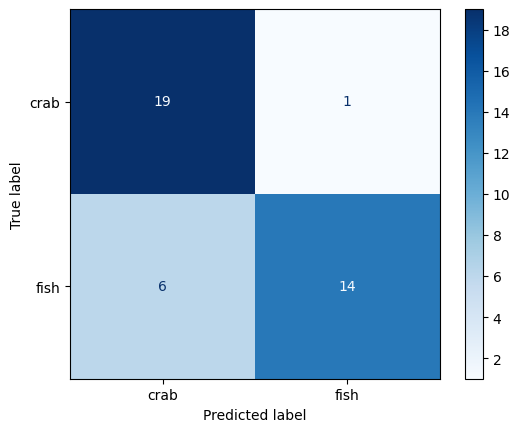

Final Test Report:
              precision    recall  f1-score   support

        crab       0.76      0.95      0.84        20
        fish       0.93      0.70      0.80        20

    accuracy                           0.82        40
   macro avg       0.85      0.82      0.82        40
weighted avg       0.85      0.82      0.82        40



['quickdraw_classes_small.joblib']

In [2]:
# Import libraries
import os  # For file and path handling
import numpy as np
import joblib  # Save and load trained models
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # Evaluation metrics



# Settings
DATA_DIR = "quickdraw_simplified"  # Folder with .npy files
CATEGORIES = ["crab", "fish"]  # Classes we want to classify
IMG_SIZE = 28  # Image dimension
N_PER_CLASS = 100  # Number of samples per class


# Load Data
X, y = [], []
for idx, category in enumerate(CATEGORIES):
    file_path = os.path.join(DATA_DIR, f"{category}.npy")  # File path for category
    data = np.load(file_path)  # Load numpy array of drawings

    data = data[:N_PER_CLASS]  # Keep only N_PER_CLASS samples
    data = data.reshape(data.shape[0], -1)  # Flatten to (N,784)
    data = data / 255.0  # Normalize pixel values to [0,1]

    X.append(data)  # Store data
    y.extend([idx] * len(data))  # Store labels, 0 for crab, 1 for fish

# Merge all categories into one dataset
X = np.vstack(X)
y = np.array(y)

print("Data shape:", X.shape, "Labels:", y.shape)



# Train/Val/Test Split
# rain+val vs test (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# train vs val (from 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)



# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "SVC": SVC(kernel='rbf', random_state=42, probability=True),
    "Voting Classifier": VotingClassifier([
        ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1)),
        ("rf", RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
        ("et", ExtraTreesClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
        ("svc", SVC(kernel='rbf', random_state=42, probability=True))
    ], voting="soft", n_jobs=-1)
}


# Train & Select Best Model
best_name, best_model, best_acc = None, None, 0

for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Train on train set
    score = model.score(X_val_scaled, y_val)  # Validate on val set
    print(f"{name} Validation Accuracy: {score:.4f}")

    if score > best_acc:  # Keep best model
        best_name, best_model, best_acc = name, model, score

print(f"\nBest model (val): {best_name} with accuracy {best_acc:.4f}")



# Final Evaluation on Test Set
y_pred = best_model.predict(X_test_scaled)

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=CATEGORIES).plot(cmap="Blues")
plt.show()

# Classification Report
print("Final Test Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))



# Save Best Model
joblib.dump(best_model, "quickdraw_model_small.joblib")
joblib.dump(scaler, "quickdraw_scaler_small.joblib")
joblib.dump(CATEGORIES, "quickdraw_classes_small.joblib")